# Phase 1  Exploring the Data from Season 1 of Game of Thrones
## Question:  How does the prominance of characters in the narration change throughout the series?

Examining how the csv files are organized , we see a seperation between a table of all the characters(nodes.csv) and
a table of all the relationships of those characters (edges.csv)

In the s1_edges dataframe: the 'Source' & 'Target' columns are the character nodes in the interactions and the 'Weight' column is the number of interactions in the scenes of the season

There are five interaction types. Character A and Character B are connected when:
1. Character A speaks directly after Character B
2. Character A speaks about Character B
3. Character C speaks about Character A and Character B
4. Character A and Character B are mentioned in the same stage direction
5. Character A and Character B appear in a scene together


In the s1_nodes dataframe: the 'Id' is the character name and 'Label' appears to be a casual version that the character is refferenced by in the series. 

In [2]:
import pandas as pd 
import networkx as n
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import skew

# Read in the csv files for season 1, season 1 edges and season 1 nodes
s1_edges = pd.read_csv('gameofthrones/data/got-s1-edges.csv')
s1_nodes = pd.read_csv('gameofthrones/data/got-s1-nodes.csv')

# Examine the first 5 rows of edges to get an idea of the column and rows
print(s1_edges.head(5), '\n')

# Examine the first 5 rows of nodes to get a dataframe of the lists of characters in GoT

print(s1_nodes.head(5))

         Source  Target  Weight  Season
0           NED  ROBERT     192       1
1      DAENERYS   JORAH     154       1
2           JON     SAM     121       1
3  LITTLEFINGER     NED     107       1
4           NED   VARYS      96       1 

               Id     Label
0  ADDAM_MARBRAND     Addam
1           AEGON     Aegon
2           AERYS     Aerys
3  ALLISER_THORNE  Allister
4            ARYA      Arya


Since the main goal involves measuring prominance , we need to define what prominance means. Every character in the edge dataframe is assigned to a target character and a corrisponding Weight of the amount of scene interactions,so we can use that weight as the value we will use.  

The 2 ways we will use the value is by counting the number of other characters a character has interacted with , and by summing the total number of interactions per character. The former gives us an idea of how influencial a character is in the story , and the latter gives us an idea how much the narration focuses on a character.

To start we will need to split the edges dataframe into 2 dataframes and duplicate the 'Weight' column. We do this because of the bi-directional nature of an interaction. Neither the 'Source' column nor 'Target' column by themselves reflect every character interaction in the show. 

Finally we take the 2 new dataframes and concat them to create a new dataframe that we will use for all our future analysis.  To test that it was appended correctly we will filter for the first 2 rows of the original daatframe: 192 and 154 intereactions respectfully. This shows us that data frame 1 was included first with 'Ned' and 'Daenerys' indexed at 0 and 1. Then dataframe 2 shows up all the way after the length of dataframe 1 with 'Robert' and 'Jorah' indexed at 550 amd 551. 



In [3]:
#Create identical column names and set the character id as index for manipulation
s1_edges_index = s1_edges.rename(columns={'Source':'Id'}).set_index('Id')
s1_nodes_index = s1_nodes.set_index('Id')

print(s1_edges_index.head(2)) 

# Seperate the edges dataframe 'Source' & 'Target' columns into 2 dataframes, copying the 'Weight' column for both 'Source' & 'Target' characters
df_2 = s1_edges_index[['Target','Weight']].reset_index().drop(['Id'], axis=1).rename(columns={'Target':'Id'})
df_1 = s1_edges_index[['Weight']].reset_index()
# Concat the 2 dataframes together to have 1 dataframe that accounts every interaction from 'Source' & 'Target'
lis = pd.concat([df_1 , df_2], sort=False, ignore_index=True)
print(lis.loc[lis['Weight']==192] , '\n', lis.loc[lis['Weight']==154] )


          Target  Weight  Season
Id                              
NED       ROBERT     192       1
DAENERYS   JORAH     154       1
         Id  Weight
0       NED     192
550  ROBERT     192 
            Id  Weight
1    DAENERYS     154
551     JORAH     154


Now that the main dataframe is created , we can group all the characters in it by both Sum and Count. And put the results in new dataframes called df_sum and df_count. As you can see the dataframes df_sum & df_count are a list of unique characters with the corrisponding Sum or Count total. 

In [4]:
# Group the dataframe by the sum of all interactions per character
df_sum = lis.groupby(lis.Id)['Weight'].sum()
# Group the dataframe by the count of characters interacted 
df_count = lis.groupby(lis.Id)['Weight'].count()
print(df_sum.head(5) , df_count.head(5))

Id
ADDAM_MARBRAND      8
AEGON               4
AERYS              41
ALLISER_THORNE     73
ARYA              373
Name: Weight, dtype: int64 Id
ADDAM_MARBRAND     3
AEGON              2
AERYS             13
ALLISER_THORNE     8
ARYA              28
Name: Weight, dtype: int64


Now let's view the distribution of all sum and count interactions. Even without checking the numbers you can see the distributions are skewed to the right. But if we calculate the skew anything greater than 1 is highly skewed right and our df_sum is greater than 3 and our df_count is greater than 2. This means the mean is greater than the median due to a couple of large values that push the mean higher. The median remains the same regardless of these outliers.

This means the season operates with a few characters getting most of the interactions and spotlight. These characters are clearly main characters, with anything lower than these extreme values likely being different levels of side characters. Let's see what we can find about the side characters. The median which is unaffected by outliers gives us the clearest picture of the behavior of a typical side character. They had around 31 interactions on screen and interacted with around 6 characters.

In future seasons I predict that the skew will greater than what it is now. As the characters being focused on get smaller with more narrative scenes invested on them. And all other characters becoming less and less relevant.  

	Skew
Sum:  3.4116588193958335  Count:  2.1968309865667


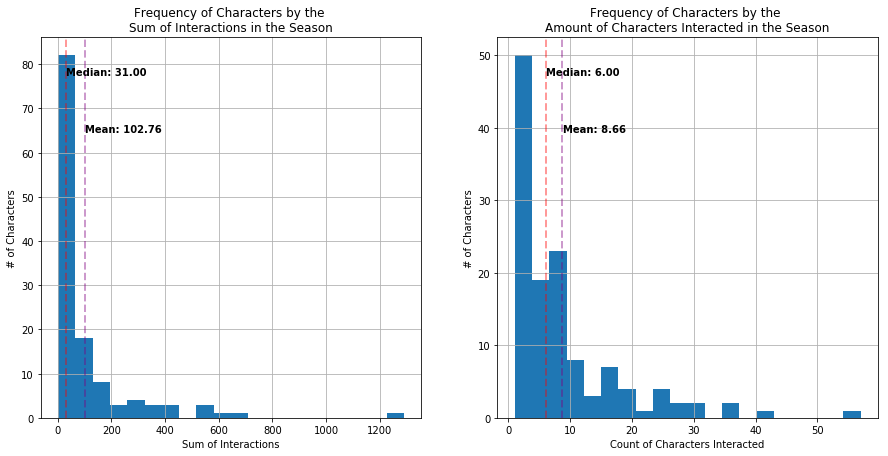

In [5]:
# The skew is greater than 1 so it is highly skewed to the right
print('\tSkew\nSum: ', skew(df_sum),' Count: ', skew(df_count))


#Create a histograph to see the distribution of the Sum and Count dataframes

plt.subplot(121)
plt.title('Frequency of Characters by the \nSum of Interactions in the Season')
df_sum.hist(figsize=(15, 7), bins=20) 
plt.axvline(df_sum.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_sum.median(), color='red', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Sum of Interactions')
_, max_ = plt.ylim()
plt.text(df_sum.mean() + df_sum.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_sum.mean()), weight='bold')
plt.text(df_sum.median() + df_sum.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_sum.median()), weight='bold')



plt.subplot(122)
plt.title('Frequency of Characters by the \nAmount of Characters Interacted in the Season')
df_count.hist(figsize=(15, 7), bins=20)
plt.axvline(df_count.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_count.median(), color='red', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Count of Characters Interacted')
_, max_ = plt.ylim()
plt.text(df_count.mean() + df_count.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_count.mean()), weight='bold')
plt.text(df_count.median() + df_count.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_count.median()), weight='bold')
plt.show()


Now let's filter and sort our values to learn the names of our most prominant characters.  First we will calculate the 95 percentile of our df_sum or df_count. We will add 1 to the resulting numbers to give us the start of the amount of total interactions or characters interacted the top 5% had. We round down those numbers because an interaction or character cannot be a decimal number. 

For example: For df_sum the bottom 95% of total interactions end at 437.99 interactions. By adding 1 to this value we learn that the top 5% of total interactions start at 438.99. Then we round down to get the true start value of 438 interactions or higher for the top 5%. The same method applyed to df_count gives us the true start value of 28 characters interacted or higher for the top 5%.

When we filter those values into our dataframes we get the list of characters for the top 5%. My assumption is that there should be a direct 1:1 correlation between the number of characters a character has interacted with and the number of total interactions the character has in the season. The characters that remain the same rank from 1st to 4th are Ned , Tyrion , Catelyn and Robert. All other characters are different in either rank or even if they appear on both lists. Let's try to explain why:

Cersei is on both lists in a different rank order. She is 5th on the Count dataframe and 6th on the Sum dataframe. This I believe is a consequence of all the other additions to the Sum dataframe. Jon and Daenerys are both on the Sum dataframe and not on the Count Dataframe. This abnormality is due to the isolation of their narratives compared to everyone else. Robb and Arya are similarily only on the Count dataframe, they are both future main characters entangled in the central Stark-Lannister conflict despite not being focused on heavily in the narrative yet. This is probably why they have a high number of characters interacted. 



In [6]:
# Calculate the 95th percentile to find where the top 5% of all summed interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total interactions were {:0.0f} interactions or higher \n'.format
      ((np.floor(df_sum.quantile(.95))+1)))

Top5_Sum=df_sum.loc[lambda x:x>=np.floor(df_sum.quantile(.95))+1].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n',Top5_Sum)
# Calculate the 95th percentile to find where the top 5% of all counted interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total characters interacted were {:0.0f} number of characters interacted or higher \n'.format
      ((np.floor(df_count.quantile(.95))+1)))
Top5_Count = df_count.loc[lambda x:x>=np.floor(df_count.quantile(.95)+1)].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n',Top5_Count)



Top 5% of total interactions were 438 interactions or higher 

This top 5% involves the following characters: 
          Id  Weight
0       NED    1290
1    TYRION     708
2   CATELYN     584
3    ROBERT     563
4       JON     535
5  DAENERYS     535
6    CERSEI     444
Top 5% of total characters interacted were 28 number of characters interacted or higher 

This top 5% involves the following characters: 
         Id  Weight
0      NED      57
1   TYRION      41
2  CATELYN      37
3   ROBERT      36
4     ROBB      30
5   CERSEI      29
6     ARYA      28


It seems like the two tables contain allot of the same characters, but in a different order. The different order might exists because of the isolation of certain prominant characters from the central conflict of the season. As well as certain less focused on characters who are part of the central conflict and so interact with an unusually high amount of characters for their current narrative value.

Now let's turn what we have done so far into a function and compare characters throughout the seasons. We can then see if these differences continue throughout the seasons.


In [21]:
def ranking(df, isSum):
    df2 = df[['Target','Weight']].rename(columns={'Target':'Id'})
    df1 = df[['Source','Weight']].rename(columns={'Source':'Id'})
    df_main = pd.concat([df2 , df1], sort=False, ignore_index=True)
   # print(df_main.head(3))
    if isSum:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].sum()
    else:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].count().reset_index()
    #print(df_groupby.head(3))
    percentile95 = np.floor(df_groupby.quantile(.95))+1 
    #print(percentile95)
    Top5=df_groupby.loc[lambda x:x>=percentile95].sort_values(ascending=False).reset_index()
    #print('--',Top5)
    pairs = dict(zip(Top5['Id'], Top5.index))
    #print(pairs)
    return pairs


In [9]:
## Using techniques on Season 2-7. Finding and comparing the distribution skews and top 5 % ranking order.

   ARYA  CERSEI  DAENERYS  DAVOS  JAIME  JOFFREY   JON  OBERYN  ROBB  SANSA  \
2   2.0     1.0       6.0   10.0   10.0      4.0  10.0    10.0   5.0   10.0   
3  10.0     4.0      10.0   10.0    5.0     10.0   6.0    10.0   1.0    3.0   
4  10.0     1.0       8.0   10.0    2.0      7.0   4.0     6.0  10.0    5.0   
5  10.0     0.0       3.0   10.0   10.0     10.0   1.0    10.0  10.0    5.0   
6   7.0     5.0       6.0    4.0    3.0     10.0   0.0    10.0  10.0    1.0   
7  10.0     3.0       1.0   10.0   10.0     10.0   0.0    10.0  10.0   10.0   

   STANNIS  THEON  TYRION  TYWIN  
2     10.0    3.0     0.0   10.0  
3     10.0   10.0     0.0    2.0  
4     10.0   10.0     0.0    3.0  
5      4.0   10.0     2.0   10.0  
6     10.0   10.0     2.0   10.0  
7     10.0   10.0     2.0   10.0  


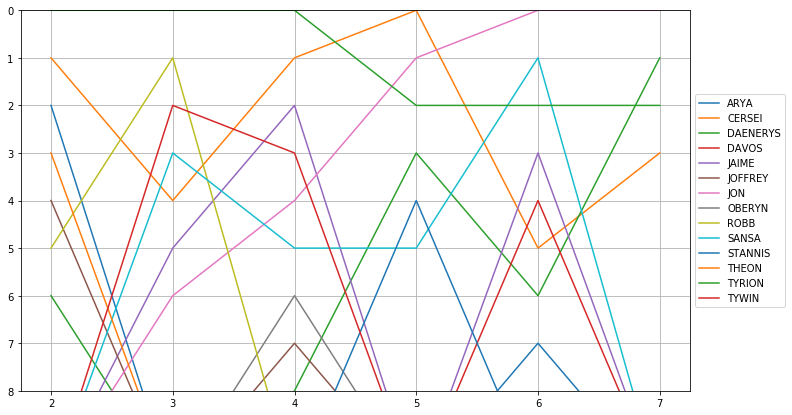

In [59]:
seasons = ['gameofthrones/data/got-s2-edges.csv', 'gameofthrones/data/got-s3-edges.csv','gameofthrones/data/got-s4-edges.csv', 
 'gameofthrones/data/got-s5-edges.csv', 'gameofthrones/data/got-s6-edges.csv', 'gameofthrones/data/got-s7-edges.csv']
#s2_edges = pd.read_csv('gameofthrones/data/got-s2-edges.csv')
#s2_edges.head(4)
#for s in ['gameofthrones/data/got-s1-edges.csv']:
season1to7 = {}
for i , s in enumerate(seasons, start=2): 
    edges = pd.read_csv(s) 
    a = ranking(edges, True)
    season1to7[i]=a
df_rank = pd.DataFrame(season1to7).fillna(10)
print(df_rank.T)
plt.figure(figsize=(12,7))
plt.ylim(8,0)
plt.plot(df_rank.T)
plt.legend(df_rank.T.columns , loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()


In [ ]:
# Calculate the 5th percentile to find where the bottom 5% of all summed interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Bottom 5% of total interactions were {:0.0f} interactions or lower \n'.format
      ((np.floor(df_sum.quantile(.05))+1)))

print('This bottom 5% involves the following characters: \n',df_sum.loc[lambda x:x<=np.floor(df_sum.quantile(.05))].sort_values(ascending=False).reset_index())
# Calculate the 5th percentile to find where the bottom 5% of all counted interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Bottom 5% of total characters interacted were {:0.0f} number of characters interacted or lower \n'.format
      ((np.floor(df_count.quantile(.05))+1)))

print('This bottom 5% involves the following characters: \n',df_count.loc[lambda x:x<=np.floor(df_count.quantile(.05))].sort_values(ascending=False).reset_index())

In [ ]:
''''print(edges.head(2))
    df2 = edges[['Target','Weight']].rename(columns={'Target':'Id'})
    df1 = edges[['Source','Weight']].rename(columns={'Source':'Id'})
    df_main = pd.concat([df2 , df1], sort=False, ignore_index=True)
    #print(df_main.head(2))
    #print(df1.head(), '\n', df2.head())
    #print(df_main.loc[df_main['Weight']==192] , '\n', df_main.loc[df_main['Weight']==154] )
    dfsum = df_main.groupby(df_main.Id)['Weight'].sum()
    dfcount = df_main.groupby(df_main.Id)['Weight'].count()
    print(df_sum.reset_index().head(5) , df_count.head(5))
    #print(dfsum.head(3), dfcount.head(3))
    print(skew(dfsum), skew(dfcount))
    sum_percentile95 = np.floor(dfsum.quantile(.95))+1
    print(sum_percentile95)
    count_percentile95 = np.floor(dfcount.quantile(.95))+1
    #print(sum_percentile95, count_percentile95)
    Top5Sum=dfsum.loc[lambda x:x>=sum_percentile95].sort_values(ascending=False).reset_index()
    Top5Count = dfcount.loc[lambda x:x>=count_percentile95].sort_values(ascending=False).reset_index()
    print(Top5Sum, '\n', Top5Count)
    pairs = list(zip(Top5Sum['Id'], Top5Sum.index))
    print('{} out of {} characters are the same which means {:.2f}'.format(len([i for i in pairs if i[0]==i[1]]),len(pairs),len([i for i in pairs if i[0]==i[1]])/len(pairs)*100))
    print(pairs, '-----') '''

In [7]:
# Percentage of the top 5% that is ordered exactly the same
pairs = list(zip(Top5_Sum['Id'], Top5_Count['Id']))
print('{} out of {} characters are the same which means {:.2f}'.format(len([i for i in pairs if i[0]==i[1]]),len(pairs),len([i for i in pairs if i[0]==i[1]])/len(pairs)*100))


4 out of 7 characters are the same which means 57.14
